In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy import signal
from scipy.integrate import trapz
from scipy.interpolate import interp1d
from matplotlib.patches import Ellipse
from scipy import interpolate
from scipy.stats import zscore

def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    # HRV metrics
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

def frequency_domain(rri, fs):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)
    
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    
    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx

def plot_poincare(rr):
    rr_n = rr[:-1]
    rr_n1 = rr[1:]

    sd1 = np.sqrt(0.5) * np.std(rr_n1 - rr_n)
    sd2 = np.sqrt(0.5) * np.std(rr_n1 + rr_n)

    m = np.mean(rr)
    min_rr = np.min(rr)
    max_rr = np.max(rr)
     
    plt.figure(figsize=(10, 10))
    plt.title("Poincare plot")

    sns.scatterplot(x=rr_n, y=rr_n1, color="#51A6D8")

    plt.xlabel(r'$RR_n (ms)$')
    plt.ylabel(r'$RR_{n+1} (ms)$')

    e1 = Ellipse((m, m), 2*sd1, 2*sd2, angle=-45, linewidth=1.2, fill=False, color="k")
    plt.gca().add_patch(e1)

    plt.arrow(m, m, (max_rr-min_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)
    plt.arrow(m, m, (min_rr-max_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)

    plt.arrow(m, m, sd2 * np.sqrt(0.5), sd2 * np.sqrt(0.5), color="green", linewidth=5)
    plt.arrow(m, m, -sd1 * np.sqrt(0.5), sd1 * np.sqrt(0.5), color="red", linewidth=5)

    plt.text(max_rr, max_rr, "SD2", fontsize=20, color="green")
    plt.text(m-(max_rr-min_rr)*0.4-20, max_rr, "SD1", fontsize=20, color="red")
    
    return sd1, sd2

# Import Data

Import raw ECG and blood pressure (BP) signals. Check your sampling rate. In this example, 1000 Hz is used.

In [2]:
path = r'./data/sample_file_HR_BraBP.txt'
df = pd.read_table(path,header=None)
df.columns = ['time','ECG','BP']
df

,time,ECG,BP
0,729.500,0.546875,85.68168
1,729.501,0.553125,85.68168
2,729.502,0.540625,85.55644
3,729.503,0.537500,85.69733
4,729.504,0.553125,85.65037
...,...,...,...
309995,1039.495,0.006250,99.16006
309996,1039.496,0.009375,99.48880
309997,1039.497,0.018750,99.81754
309998,1039.498,0.003125,99.91147


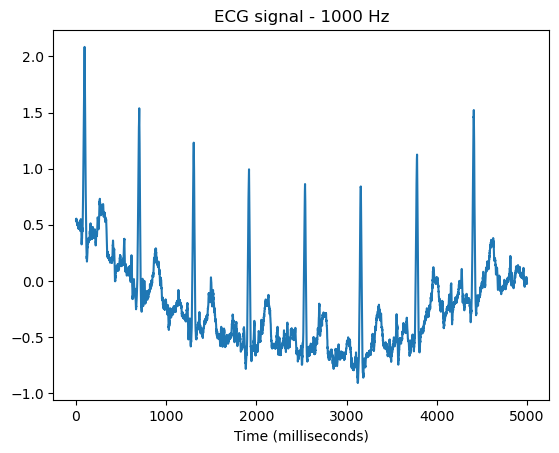

In [3]:
# sample of a relatively clean 5 second recording of ECG signal
# the 2-lead ECG sensor returns values in real voltages

plt.title("ECG signal - 1000 Hz")
plt.plot(df['ECG'][0:5000])
plt.xlabel('Time (milliseconds)')
plt.show()

# RR peak detection

Detecting the QRS complex of the ECG signal. The R-wave spike is the most striking part of the ECG signal - it reflects the depolarization of the hearts ventricles. This is done in two parts
1) Apply transformation: constructing a signal that will maximize the features we are most interested in... i.e. the QRS complex
2) Decision rule: a threshold to seperate the desired features from the rest of the signal (reducing the noise)

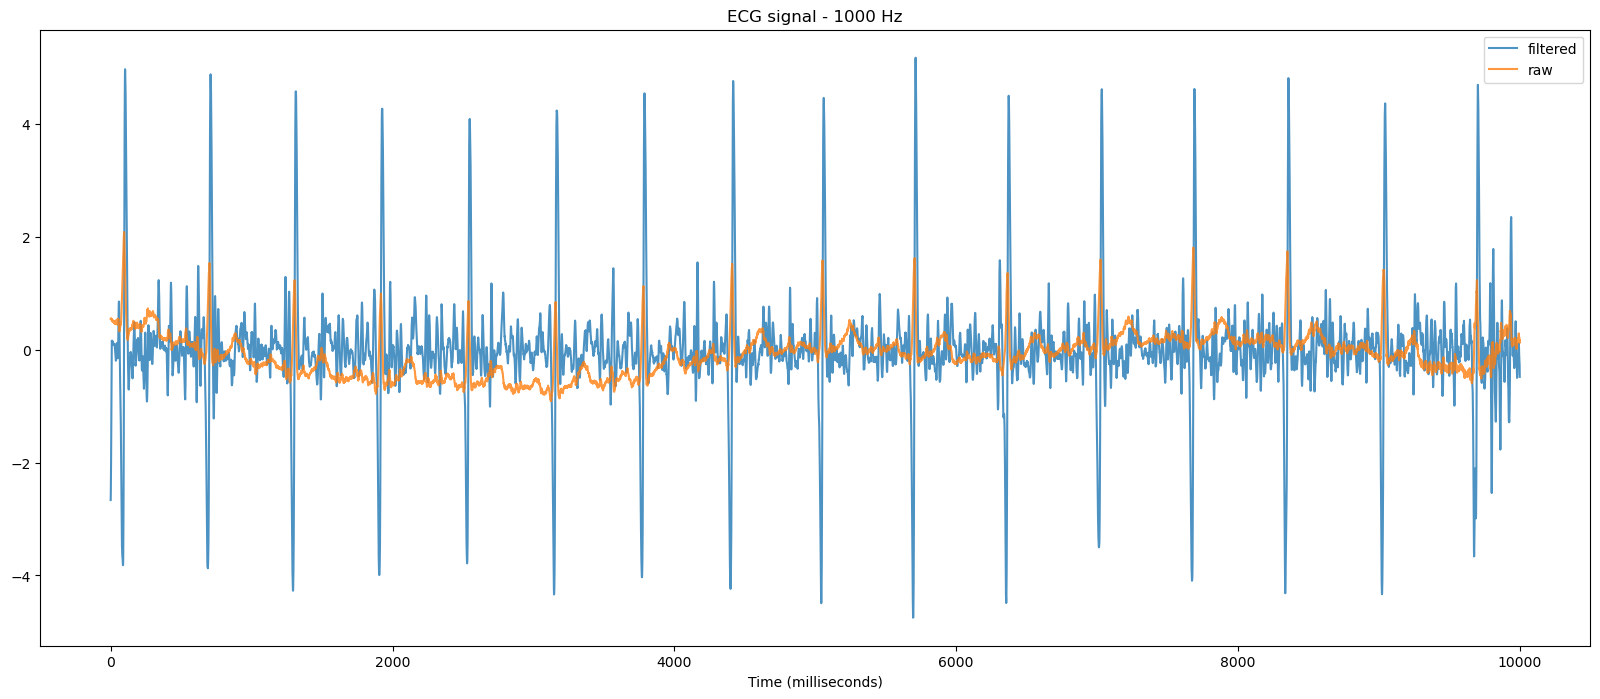

In [4]:
# linear spaced vector between 0.5 pi and 1.5 pi 
t = np.linspace(0.5 * np.pi, 1.5 * np.pi, 15)

# sine filter
sine_filt = np.sin(t)

# compute cross correlation between ecg and the sine filter
ecg_transformed = np.correlate(df['ECG'], sine_filt, mode='same')

plt.figure(figsize=(20,8))
plt.title('ECG signal - 1000 Hz')
plt.plot(ecg_transformed[0:10000], alpha = 0.8)
plt.plot(df['ECG'][0:10000], alpha = 0.8)
plt.gca().legend(('filtered','raw'))
ax = plt.xlabel('Time (milliseconds)')

plt.show()

In [5]:
diff_sig_ecg=np.diff(ecg_transformed)

rr_peaks_ecg= find_peaks(diff_sig_ecg, distance=1000*(30/60), prominence=0.01)
rr_peaks = rr_peaks_ecg[0]

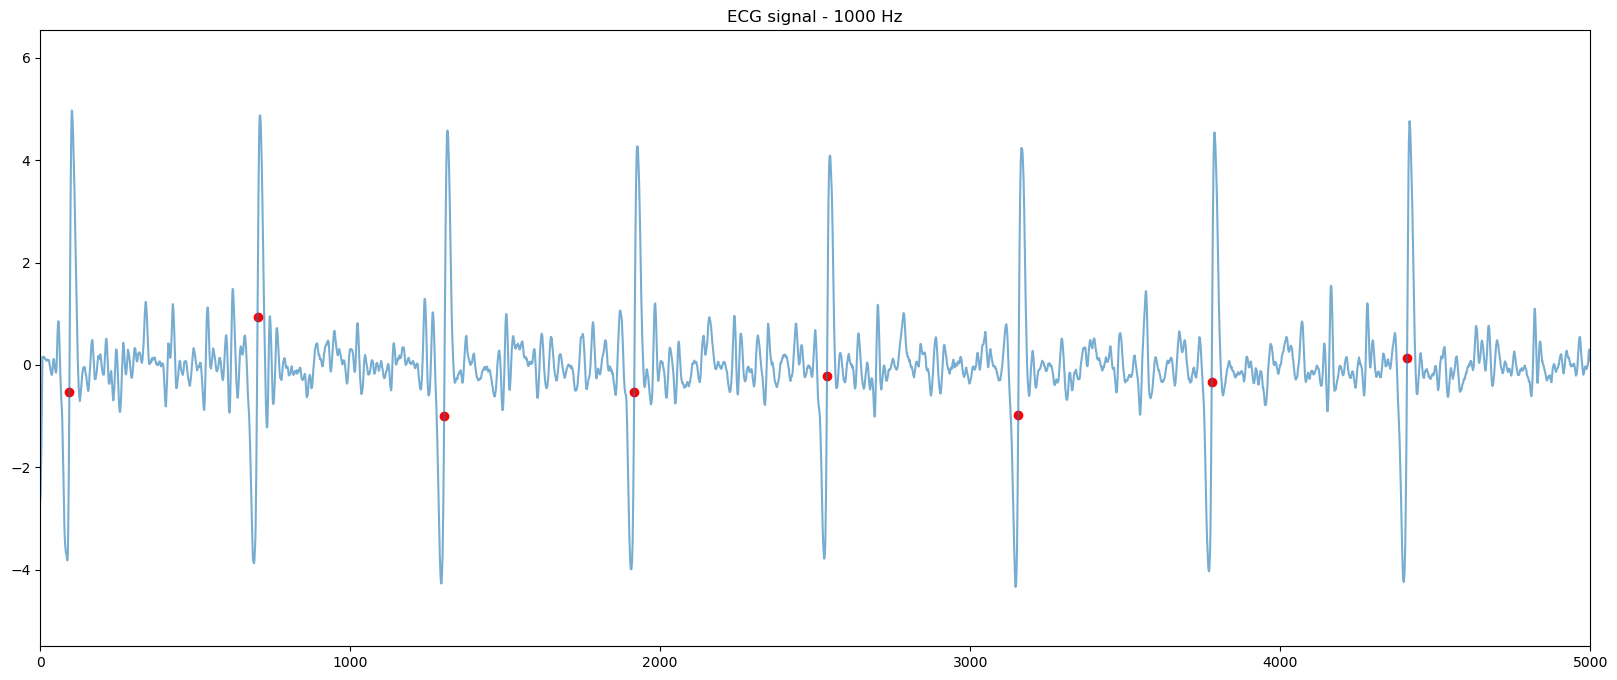

In [7]:
# plot 5 second sample of detection result

df_ecg = df[['time','ECG']]

plt.figure(figsize=(20,8))
plt.plot(ecg_transformed, alpha = 0.6)
plt.scatter(rr_peaks, ecg_transformed[rr_peaks], color='red')
plt.xlim(0,5000)
plt.title("ECG signal - 1000 Hz")
plt.show()

In [8]:
# the R-R intervals
rr_ecg = np.diff(rr_peaks)
rr_ecg

array([607, 602, 613, 622, 617, 624, 630, 642, 652, 660, 659, 660, 667,
       683, 661, 638, 640, 624, 613, 610, 618, 631, 651, 668, 663, 663,
       648, 658, 673, 686, 702, 689, 673, 666, 684, 696, 691, 721, 686,
       664, 659, 662, 683, 681, 665, 659, 674, 687, 708, 705, 671, 658,
       679, 680, 680, 670, 661, 654, 665, 704, 727, 715, 678, 656, 658,
       674, 688, 686, 662, 651, 665, 674, 674, 702, 685, 684, 705, 701,
       700, 696, 672, 667, 664, 671, 678, 674, 654, 645, 661, 660, 677,
       687, 670, 645, 658, 679, 667, 650, 636, 648, 659, 659, 659, 658,
       670, 680, 681, 649, 654, 666, 661, 669, 657, 640, 645, 670, 675,
       703, 684, 661, 663, 674, 667, 669, 661, 657, 678, 674, 663, 645,
       641, 663, 685, 685, 669, 655, 657, 671, 698, 680, 656, 642, 650,
       673, 690, 669, 646, 657, 678, 693, 686, 653, 650, 651, 645, 643,
       635, 624, 631, 656, 669, 691, 684, 657, 641, 661, 647, 628, 623,
       625, 647, 658, 647, 631, 618, 635, 635, 636, 627, 617, 59

In [9]:
# a look at the timedomain metrics for the sample
timedomain(rr_ecg)

{'Mean RR (ms)': 653.6582278481013,
 'STD RR/SDNN (ms)': 30.339104318814627,
 "Mean HR (Kubios' style) (beats/min)": 91.79108813106372,
 'Mean HR (beats/min)': 91.98998755381686,
 'STD HR (beats/min)': 4.306791180834402,
 'Min HR (beats/min)': 76.62835249042146,
 'Max HR (beats/min)': 118.34319526627219,
 'RMSSD (ms)': 18.089628860328776,
 'NNxx': 3,
 'pNNxx (%)': 0.6329113924050633}

In [10]:
#time axis
x_ecg = np.cumsum(rr_ecg)/1000

#fit function to the dataset
f_ecg = interp1d(x_ecg, rr_ecg, kind='cubic', fill_value= 'extrapolate')

#sample rate for interpolation
fs = 4
steps = 1 / fs

#sample using the interpolation function
xx_ecg = np.arange(0, np.max(x_ecg), steps)

rr_interpolated_ecg = f_ecg(xx_ecg)

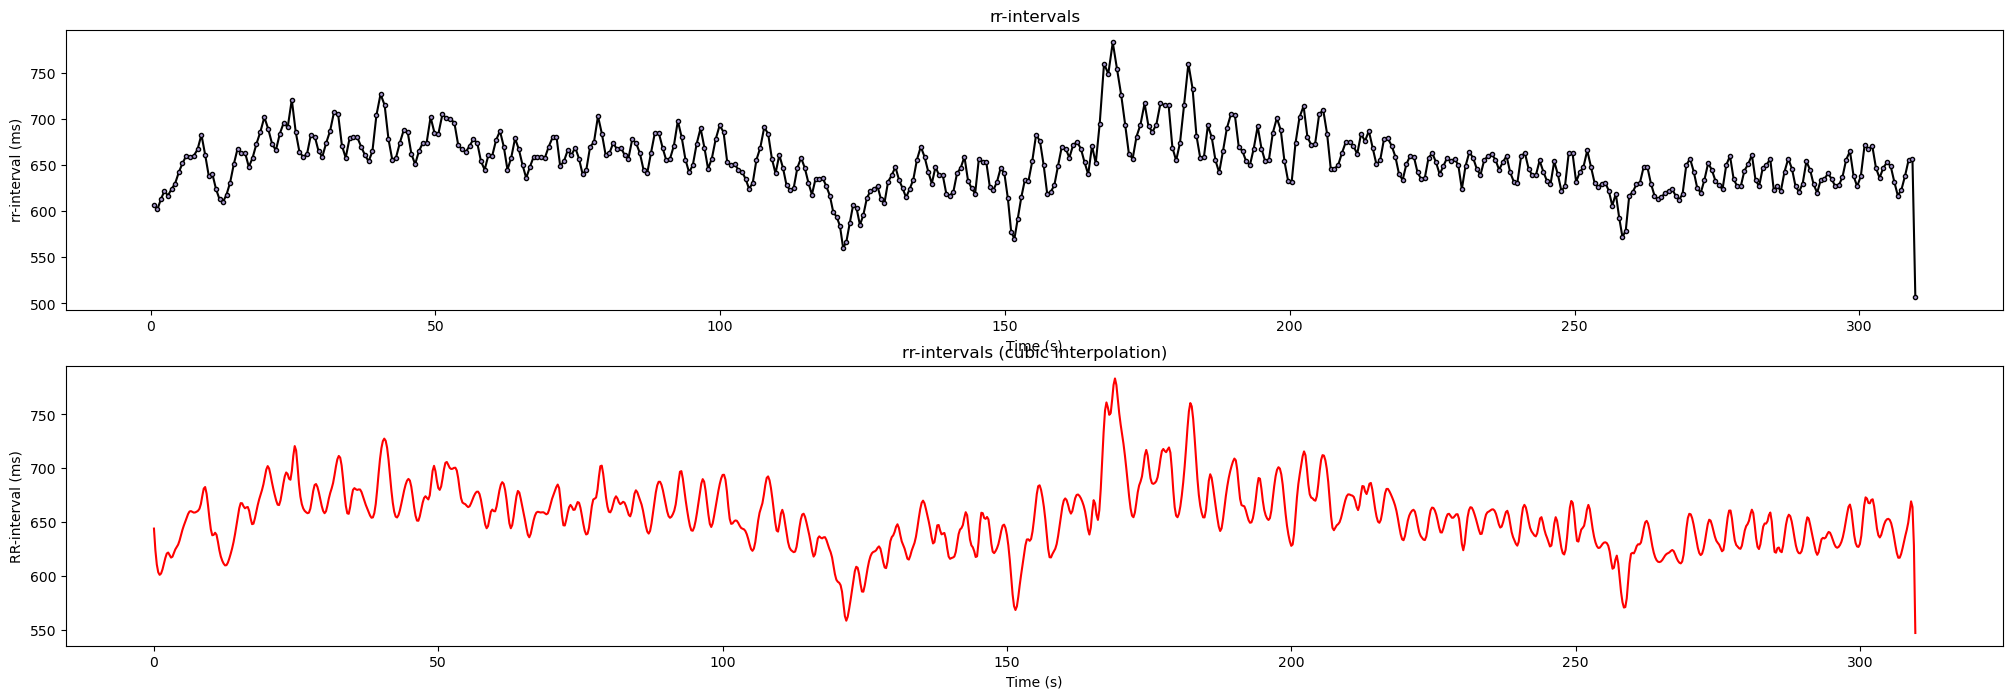

In [13]:
plt.figure(figsize=(25,8))

plt.subplot(211)
plt.title('rr-intervals')
plt.plot(x_ecg, rr_ecg, color='k', markerfacecolor='#A999D1',marker='o', markersize=3)
plt.xlabel('Time (s)')
plt.ylabel('rr-interval (ms)')

plt.subplot(212)
plt.title('rr-intervals (cubic interpolation)')
plt.plot(xx_ecg, rr_interpolated_ecg, color='r')
plt.xlabel('Time (s)')
plt.ylabel('RR-interval (ms)')

plt.show()

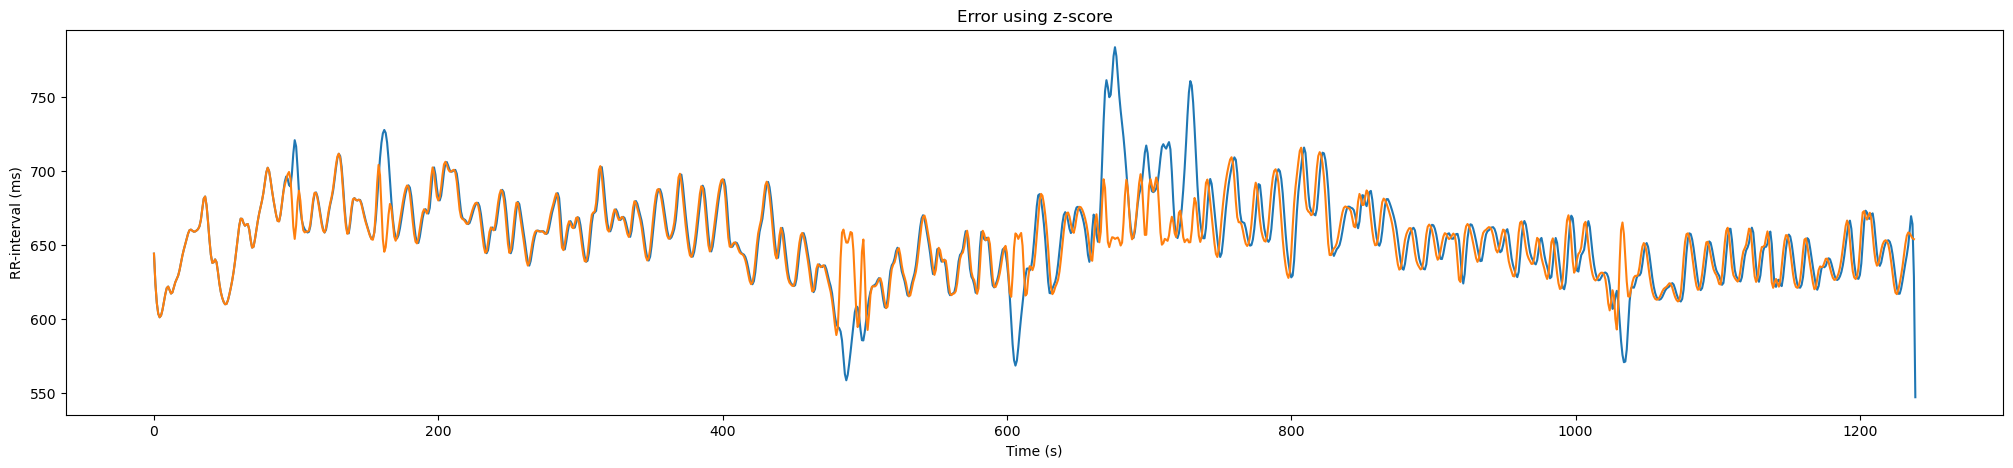

In [14]:
# we have a few false peak detections, lets replace them with the data medium
rr_ecg[np.abs(zscore(rr_ecg)) > 2] = np.median(rr_ecg)


x_ecg = np.cumsum(rr_ecg)/1000
f_ecg = interp1d(x_ecg, rr_ecg, kind='cubic', fill_value= 'extrapolate')

xx_ecg = np.arange(0, np.max(x_ecg), steps)
clean_rr_interpolated_ecg = f_ecg(xx_ecg)

plt.figure(figsize=(25,5))
plt.title('Error using z-score')
plt.plot(rr_interpolated_ecg)
plt.plot(clean_rr_interpolated_ecg)
plt.xlabel('Time (s)')
plt.ylabel('RR-interval (ms)')

plt.show()

In [15]:
x = np.arange(0, 10)
y = np.exp(x/3.0)
predict = interpolate.interp1d(x, y, kind='quadratic')

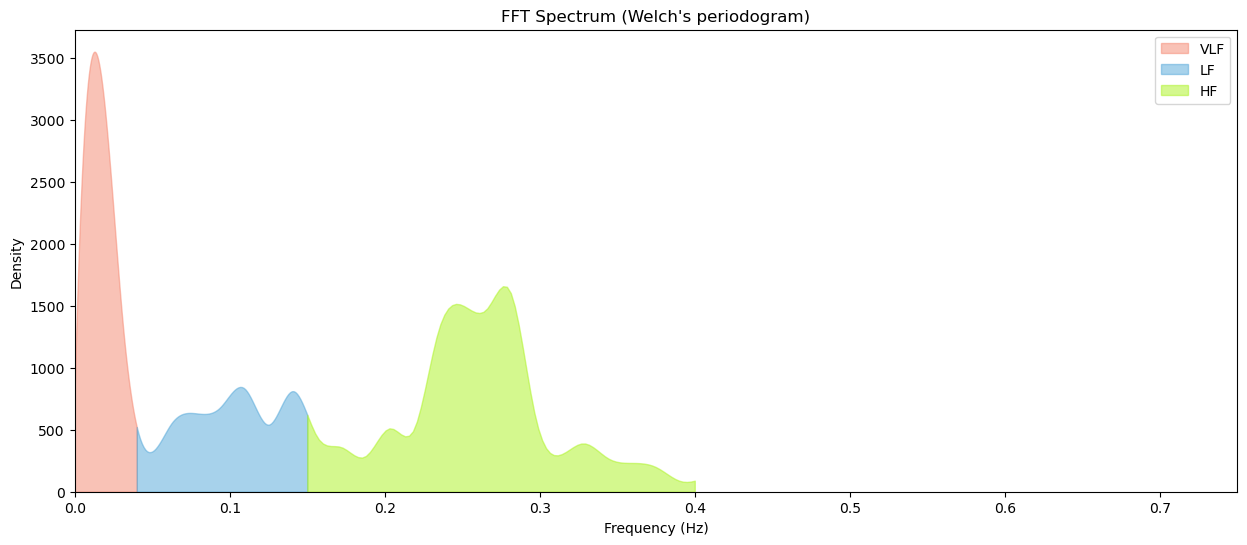

In [16]:
fxx, pxx = signal.welch(x=clean_rr_interpolated_ecg, fs=fs, nperseg=256)

#fit a function for plotting bands
powerspectrum_f = interp1d(fxx, pxx, kind='cubic', fill_value= 'extrapolate')

plt.figure(figsize=(15,6))
# plt.plot(fxx,pxx,color='k',linewidth=0.5)
plt.title("FFT Spectrum (Welch's periodogram)")

# setup frequency bands for plotting
x_VLF = np.linspace(0, 0.04, 100)
x_LF = np.linspace(0.04, 0.15, 100)
x_HF = np.linspace(0.15, 0.4, 100)

plt.gca().fill_between(x_VLF, powerspectrum_f(x_VLF), alpha=0.5, color="#F5866F", label="VLF")
plt.gca().fill_between(x_LF, powerspectrum_f(x_LF), alpha=0.5, color="#51A6D8", label="LF")
plt.gca().fill_between(x_HF, powerspectrum_f(x_HF), alpha=0.5, color="#ABF31F", label="HF")

plt.gca().set_xlim(0, 0.75)
plt.gca().set_ylim(0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")

plt.legend()
plt.show()

In [17]:
#frequency bands: very low frequency (VLF), low frequency (LF), high frequency (HF) 
cond_VLF = (fxx >= 0) & (fxx < 0.04)
cond_LF = (fxx >= 0.04) & (fxx < 0.15)
cond_HF = (fxx >= 0.15) & (fxx < 0.4)

#calculate power in each band by integrating the spectral density using trapezoidal rule 
VLF = trapz(pxx[cond_VLF], fxx[cond_VLF])
LF = trapz(pxx[cond_LF], fxx[cond_LF])
HF = trapz(pxx[cond_HF], fxx[cond_HF])

#total power sum
total_power = VLF + LF + HF

# calculate power in each band by integrating the spectral density 
vlf = trapz(pxx[cond_VLF], fxx[cond_VLF])
lf = trapz(pxx[cond_LF], fxx[cond_LF])
hf = trapz(pxx[cond_HF], fxx[cond_HF])
    

#peaks (Hz) in each band
peak_VLF = fxx[cond_VLF][np.argmax(pxx[cond_VLF])]
peak_LF = fxx[cond_LF][np.argmax(pxx[cond_LF])]
peak_HF = fxx[cond_HF][np.argmax(pxx[cond_HF])]

#fractions
LF_nu = 100 * lf / (lf + hf)
HF_nu = 100 * hf / (lf + hf)

results = {}
results['Power VLF (ms2)'] = VLF
results['Power LF (ms2)'] = LF
results['Power HF (ms2)'] = HF   
results['Power Total (ms2)'] = total_power

results['LF/HF'] = (LF/HF)
results['Peak VLF (Hz)'] = peak_VLF
results['Peak LF (Hz)'] = peak_LF
results['Peak HF (Hz)'] = peak_HF

results['Fraction LF (nu)'] = LF_nu
results['Fraction HF (nu)'] = HF_nu

results

{'Power VLF (ms2)': 71.04902323881217,
 'Power LF (ms2)': 59.59617305426582,
 'Power HF (ms2)': 153.27450484142182,
 'Power Total (ms2)': 283.9197011344998,
 'LF/HF': 0.3888198700489959,
 'Peak VLF (Hz)': 0.015625,
 'Peak LF (Hz)': 0.109375,
 'Peak HF (Hz)': 0.28125,
 'Fraction LF (nu)': 27.996421885530683,
 'Fraction HF (nu)': 72.00357811446932}

(12.062221080245372, 30.295853256317695)

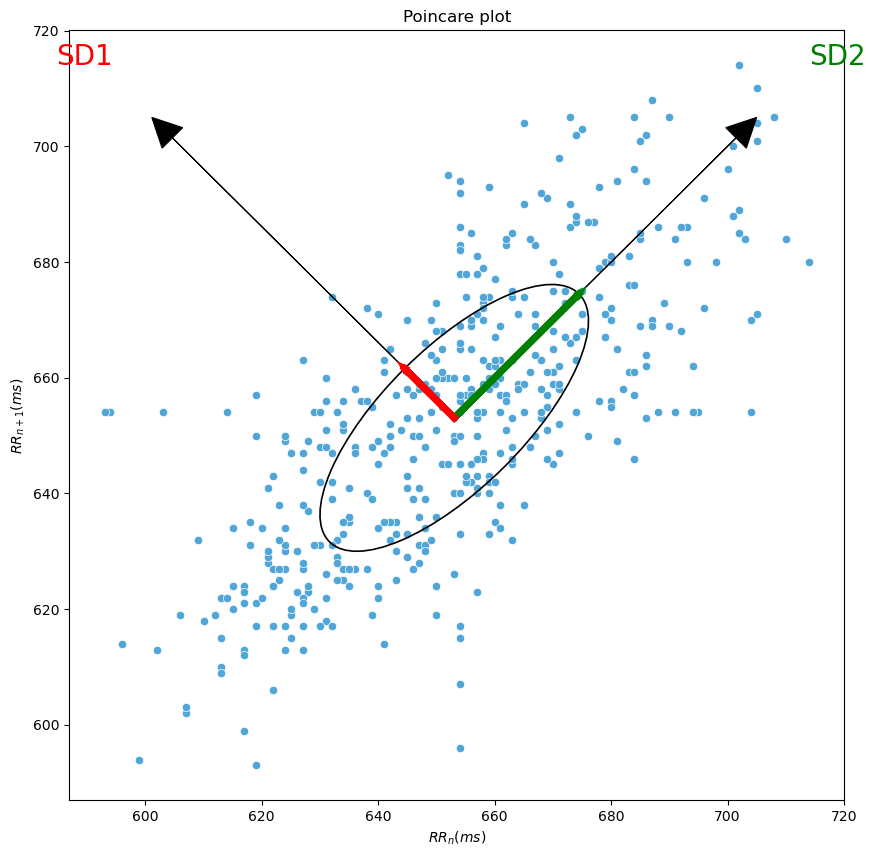

In [18]:
plot_poincare(rr_ecg)